In [1]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
using OrdinaryDiffEq
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using NonlinearSolve
using SteadyStateDiffEq 
using BenchmarkTools

In [ ]:
""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end


""" Create a random distribution, save it, computes the corresponding parameters an return the stationnary state. 
If compute_t_evolution, compute the whole evolution, else only the stationnary state. """
function solve_random_distrib(chunk, f, op_list, compute_t_evolution, N, n, d0_lb)
    popup_ss, popup_t = [], []
    nbr_error_ss, nbr_error_t = [], []
    sol_t = []

    for i in chunk
        # Compute distribution
        L = (N/n)^(1/3) # Change the volume to keep the density cste
        r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]

        # Choose a distribution where the minimum distance between the atoms is bigger than d0_min
        while min_r0(r0) < d0_lb
            r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]
        end

        # Save the atoms position for comparison with QuantumOptics
        @save "r0/r0_N_$(N)_r_$i.jdl2" r0 L

        # Compute the parameters
        system = SpinCollection(r0, e, gammas=1.)
        Ω_CS = OmegaMatrix(system)
        Γ_CS = GammaMatrix(system)
        Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
        Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
        exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
        conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
        p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

         # Load the functions
        fsolve(du, u, p, t) = f(du, u, p0)

        ## Compute stationnary state ##
        # Prepare the final state guess
        phi_array_f, theta_array_f = zeros(N), ones(N)*π # We start from all the atoms in the GS
        uf = u0_CFunction(phi_array_f, theta_array_f, op_list)

        ## Computation steady state ##
        prob_ss = SteadyStateProblem(fsolve, uf)
        sol_ss = solve(prob_ss, SSRootfind(); abstol=1e-3, reltol=1e-3, maxiters=1_000_000)

        while ~SciMLBase.successful_retcode(sol_ss)
            phi_array_f, theta_array_f = zeros(N), ones(N)*rand()*π/2 # We start from all the atoms in the GS
            uf = u0_CFunction(phi_array_f, theta_array_f, op_list)
            prob_ss = SteadyStateProblem(fsolve, uf)
            sol_ss = solve(prob_ss, SSRootfind(); abstol=1e-3, reltol=1e-3, maxiters=1_000_000)
        end


        print(SciMLBase.successful_retcode(sol_ss))




        # sol_ss = solve(prob_ss, DynamicSS(Tsit5()))
        # if SciMLBase.successful_retcode(sol_ss)
        push!(popup_ss, sum(real(sol_ss[1:N])))

        if ~SciMLBase.successful_retcode(sol_ss)
            push!(nbr_error_ss, i)
        end
        
        # else
        #     push!(nbr_error_ss, i)
        # end

        ## Compute evolution ##
        if compute_t_evolution
            # Prepare the initial state
            phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
            u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

            prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))

            sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
                        reltol=1.0e-6,
                        abstol=1.0e-8)

            if SciMLBase.successful_retcode(sol)
                push!(popup_t, [sum(real(sol.u[i][1:N])) for i=1:length(T)])
                push!(sol_t, sol.u)
            else
                push!(nbr_error_t, i)
            end
        end
    end
    return popup_ss, popup_t, nbr_error_ss, nbr_error_t, sol_t 
end

""" Return the minimum distance of a distribution of atoms r0 """
function min_r0(r0)
    N = length(r0)
    d0 = zeros(N, N) # Repetiton, atom i, distance from atom j
    for j in 1:N
        for k = 1:N
            d0[j, k] = norm(r0[j]-r0[k])
        end
    end
    return minimum(d0[d0 .> 0])
end

""" Return the minimum distance of a distribution of atoms r0 """
function avg_r0(r0)
    N = length(r0)
    d0 = zeros(N, N) # Repetiton, atom i, distance from atom j
    for j in 1:N
        for k = 1:N
            d0[j, k] = norm(r0[j]-r0[k])
        end
    end
    return mean(d0)*N/(N-1)
end

""" Reconstruct the position of atoms """
function reconstruct_img_distrib(N, i)
    @load "r0/r0_N_$(N)_r_$i.jdl2" r0 L
    plt.close("all")
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter([r[1] for r in r0], [r[2] for r in r0], [r[3] for r in r0])
    ax.set_xlabel(L"x/$\lambda$")
    ax.set_ylabel(L"y/$\lambda$")
    ax.set_zlabel(L"z/$\lambda$")
    ax.set_xlim(0, L), ax.set_ylim(0, L), ax.set_zlim(0, L)
    plt.savefig("Images_distribution/IImages_distribution_N_$(N)_r_$i")
end

reconstruct_img_distrib

### Define the system

In [5]:
# Nbr of particles
N = 4
r = 10 # Nbr of repetitions

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Fixed density
n0 = 2e3 # atoms per unit of volume (already normalized)
d0_lb = 2e-10 # Minimum distance between the atoms (lower boundary) in m

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
Ω_RO = Ω_RO / γ
d0_lb = d0_lb/λ

# Quantization axis along z
e = [0, 0, 1.]

# Integration parameter
tstep = 0.1
T = [0:tstep:100;]; # Normalised time

### Compute stationnary state for r repetitions

In [6]:
# Create the directories
if !isdir("r0")
    mkdir("r0")
end
if !isdir("Images_distribution")
    mkdir("Images_distribution")
end
if !isdir("solutions")
    mkdir("solutions")
end
nothing 

In [7]:
# Prepare the function
libpath ="libs/liballfuncs_$N.dll"
f(du, u, params) = ccall(("diffeqf", libpath), Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)

f (generic function with 1 method)

In [ ]:
@load "op_list/op_list_$N.jdl2" op_list
list_r = 1:r
chunks = Iterators.partition(list_r, cld(length(list_r), Threads.nthreads()))
tasks = map(chunks) do chunk # Split the different distributions into chuncks solved on each core
    Threads.@spawn solve_random_distrib(chunk, f, op_list, true, N, n0, d0_lb)
end


# Gather the data from the different threads
sol_tasks = fetch.(tasks)
popup_ss = vcat([s[1] for s in sol_tasks]...)
popup_t = vcat([s[2] for s in sol_tasks]...)
nbr_error_ss = vcat([s[3] for s in sol_tasks]...)
nbr_error_t = vcat([s[3] for s in sol_tasks]...)
# print("Nbr errors = "*string(length(nbr_error)))
nbr_error_ss

true

In [ ]:
popup_t

2-element Vector{Any}:
 [3.749399456654644e-32, 0.0011596712245556609, 0.003145710987002418, 0.005244021003702759, 0.007600728670916879, 0.010070046410491114, 0.012484727564986649, 0.014888401567812987, 0.017179177620587172, 0.019072521972428938  …  0.04159818561239996, 0.0415994916443342, 0.04160081722347247, 0.04160187316952992, 0.04160296798853881, 0.04160433723200313, 0.041605627951079124, 0.04160663762311712, 0.04160767314257524, 0.041608781621368926]
 [3.749399456654644e-32, 0.000645832508985349, 0.0011831479964087574, 0.0023599960916669068, 0.0038054564909608896, 0.005515916497271022, 0.007314370541179039, 0.009451527894745565, 0.01147951879763326, 0.013711950969261333  …  0.04307337829104291, 0.0430729436148973, 0.04307314058644419, 0.043073371947352806, 0.04307281109515167, 0.04307344071115129, 0.043073304703141614, 0.04307312630555588, 0.043073658552668696, 0.0430730347279045]

In [ ]:
@save "solutions/sol_N_$(N)_r_$(r)" popup_ss popup_t nbr_error_ss nbr_error_t

In [ ]:
@load "solutions/sol_N_$(N)_r_$(r)" popup_ss popup_t nbr_error_ss nbr_error_t

# Plots

In [71]:
popup_t

10-element Vector{Any}:
 [1.4997597826618576e-32, 0.0003669951357581129, 0.0012376353471988193, 0.0022700245350434907, 0.0031637422176251746, 0.0037147440147982185, 0.0038462762535144282, 0.003562846002135627, 0.002940709455075785, 0.0021598883304005546  …  0.0017290215682207897, 0.0017290278698612585, 0.0017290387151497253, 0.001729048739168206, 0.0017290515518953043, 0.0017290540135522533, 0.0017290616303004018, 0.0017290732831900038, 0.001729082344533161, 0.0017290850743872294]
 [1.4997597826618576e-32, 7.112188730079116e-5, 7.37681446755904e-5, 3.531216100009638e-6, 4.715918719792894e-5, 6.344025754326733e-5, 1.0194573372368359e-5, 3.381751368380687e-5, 5.509052331016247e-5, 1.6749083377279756e-5  …  3.024427095347578e-5, 3.024223911484183e-5, 3.0243737597989148e-5, 3.0244680086635103e-5, 3.024243000753482e-5, 3.024412096817643e-5, 3.0245177563421522e-5, 3.0243244200480345e-5, 3.0245085194152964e-5, 3.0245699122779504e-5]
 [1.4997597826618576e-32, 0.0005798338965659805, 0.001956091

0.013321348657771572

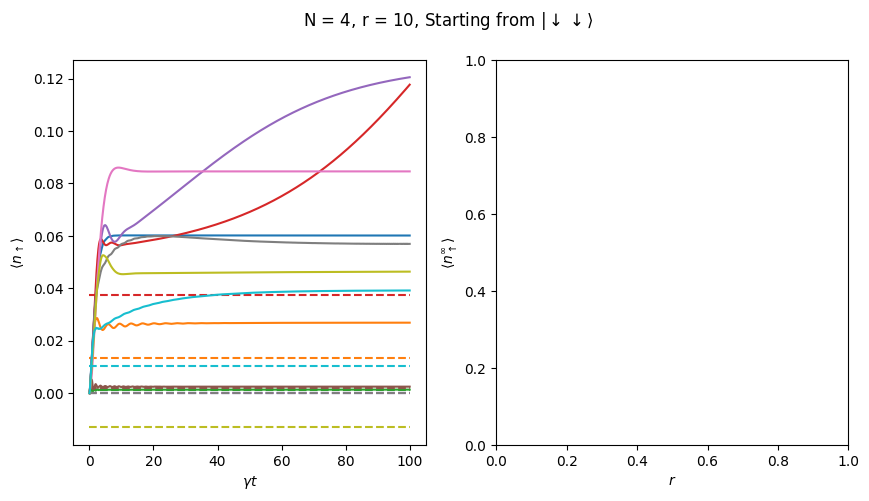

In [83]:
fig, axes = subplots(1, 2, figsize = (10, 5))
for i in 1:length(popup_ss)
    line, = axes[1].plot(T, popup_t[i])
    axes[1].hlines(popup_ss[i], T[1], T[end], linestyle="--", color = line.get_color())
end
axes[1].set_xlabel(L"$\gamma t$")
axes[1].set_ylabel(L"$\langle  n_{\uparrow} \rangle $")

# axes[2].scatter([i for i in 1:r if i ∉ nbr_error_ss], popup_ss)
# axes[2].hlines(mean(popup_ss), 1, r, color="black")
axes[2].set_xlabel(L"r")
axes[2].set_ylabel(L"$\langle  n_{\uparrow}^\infty \rangle$")
print(std(popup_ss))


suptitle("N = $N, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false);
# pygui(true); show()

# Finding directly the SS

### Stats on distance between atoms

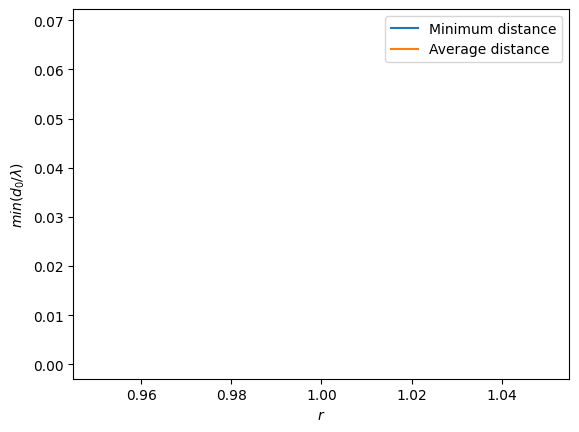

In [11]:
close("all")
figure()
min_d0 = []
avg_d0 = []

for i = 1:r
    @load "r0/r0_N_$(N)_r_$i.jdl2" r0 L
    push!(min_d0, min_r0(r0))
    push!(avg_d0, avg_r0(r0))
end
plot(1:r, min_d0, label="Minimum distance")
plot(1:r, avg_d0, label="Average distance")
hlines(d0_lb, 1, r, linestyle="--")
legend()
xlabel(L"r")
ylabel(L"min(d_0/\lambda)")
pygui(false);

In [ ]:
fig, ax = subplots()
ax.plot([i for i in 1:r if i ∉ nbr_error], popup_SS, label="Stationnary State")
ax.plot([i for i in 1:r], min_d0, label="Minimum distance between atoms")
ax.plot([i for i in 1:r], avg_d0, label="Average distance between atoms")
for i in nbr_error
    scatter(i, min_d0[i], color="r")
end
legend()
xlabel("r")

# Distributions that did not work

In [ ]:
close("all")
figure()
min_d0_err = []
avg_d0_err = []

for i in nbr_error
    @load "r0/r0_N_$(N)_r_$i.jdl2" r0 L
    push!(min_d0_err, min_r0(r0))
    push!(avg_d0_err, avg_r0(r0))
end
scatter(nbr_error, min_d0_err, label="Minimum distance")
scatter(nbr_error, avg_d0_err, label="Average distance")
hlines(d0_lb, 1, r, linestyle="--")
legend()
xlabel(L"r")
ylabel(L"min(d_0/\lambda)")
pygui(false);

In [ ]:
for i in nbr_error
    reconstruct_img_distrib(N, i)
end

In [ ]:
popup_SS_err, popup_t_err = [], []

for i in nbr_error
    @load "r0/r0_N_$(N)_r_$i.jdl2" r0 L

    # Compute the parameters
    system = SpinCollection(r0, e, gammas=1.)
    Ω_CS = OmegaMatrix(system)
    Γ_CS = GammaMatrix(system)
    Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
    Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
    exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
    conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
    p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

        # Load the functions
    fsolve(du, u, p, t) = f(du, u, p0)

    ## Compute stationnary state ##
    # Prepare the initial state
    phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
    u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

    # Computation
    prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))

    sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
                reltol=1.0e-6,
                abstol=1.0e-8)

    if SciMLBase.successful_retcode(sol)
        push!(popup_SS_err, sum(real(sol.u[end][1:N])))
        push!(popup_t_err, [sum(real(sol.u[i][1:N])) for i=1:length(T)])
    else
        print("Error")
    end
end

# Brouillons

In [ ]:
                # @warn "Solve failed with retcode = $(sol.retcode). Retrying…"
#                 phi_array_f, theta_array_f = zeros(N), ones(N)*7π/8 # We start from all the atoms in the GS
# uf = u0_CFunction(phi_array_f, theta_array_f, op_list)
# sol_tasks[1][5][1][end]